<a href="https://colab.research.google.com/github/ye3072/single-cell-binary-classification-tutorials/blob/main/single_cell_deep_learning_walkthrough.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scanpy==1.9.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import torch
import umap
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix

## Deep learning overview

The goal of any good deep learning model is to accomplish some task and/or extract **useful** information from input data. This could take several forms, such as classifying, clustering, or embedding (i.e. generating new features for) the input samples.

We tell the model **how** to extract the information we want it to by defining a **loss function**.

At a high level, neural networks accromplish their task by *transforming* input features into more useful representations. Below is an example of a hypothetical dataset where we go from input features that are not meaningful to the task at hand (such as clustering samples by type), to a representation that is more meaningful (the samples seperate by type). You can call this new representation by a lot of names (feature space, embedding space, latent space, etc.). But the main idea is that this new transformed feature space is more meaningful to the task to be accomplished.

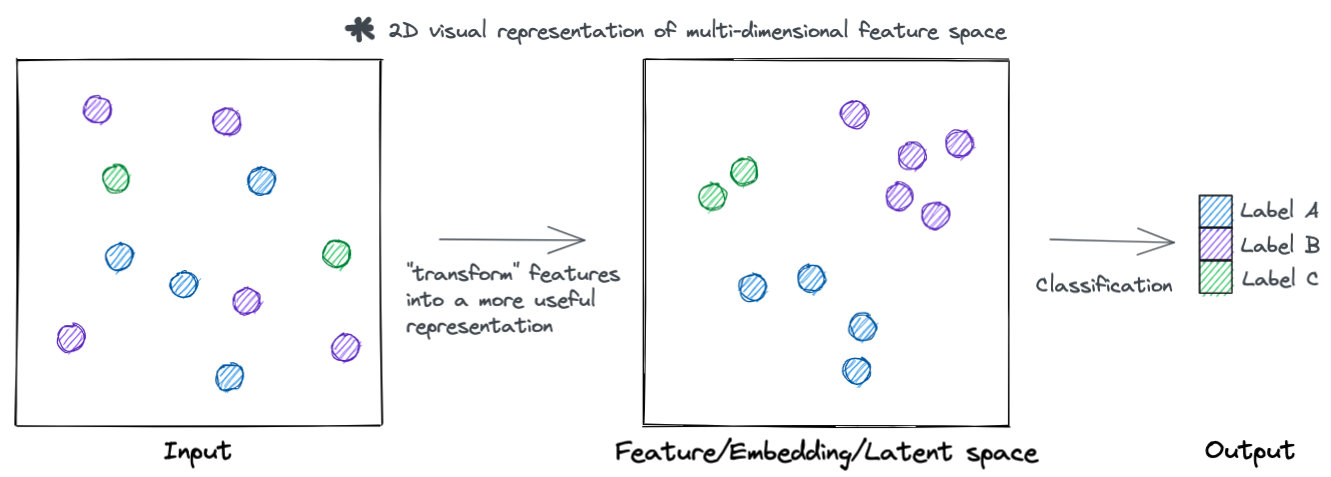

Lets go a little deeper, rather then just visualizing these hypothetical samples. Each sample has a set of **features** that describe it. For example, in single cell data each *cell* (sample) has a set of *genes* (features) that describe it.

These features are represented as **tensors**, which is just a fancy name for a vector (i.e. collection of numeric values associated with a sample).

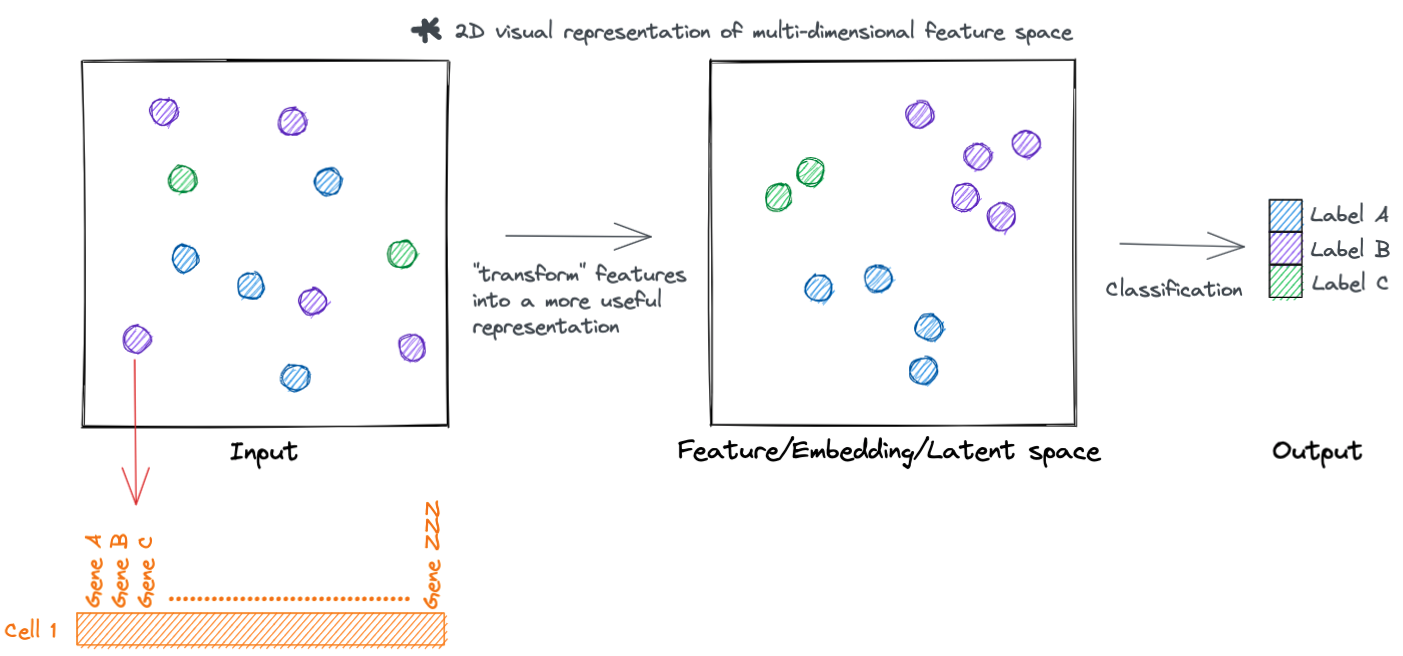

Similarly, we can represent the transformed feature space as a tensor.

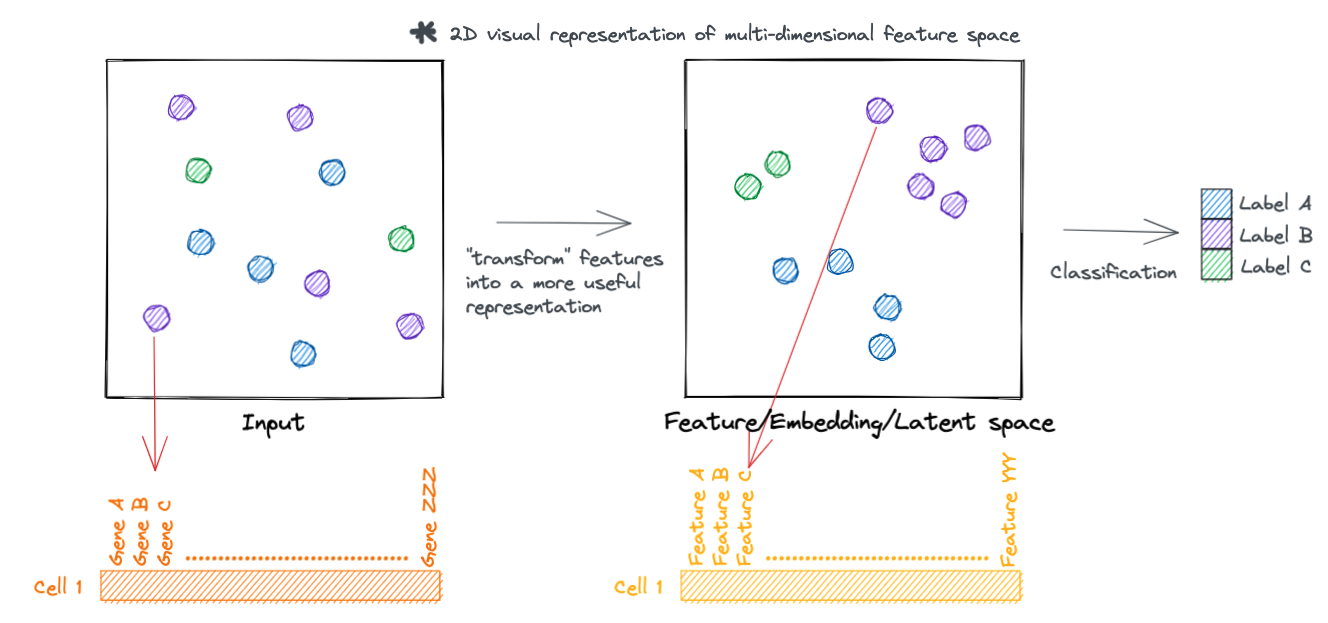

## A code walkthrough: Simplified Pollock

Pollock is a single cell classification tool. Here we'll make a simplified version from the ground up.

In doing so, we'll (hopefully) build an intuition for basic machine learning data preprocessing and deep learning.

Pollock github link: https://github.com/ding-lab/pollock

#### Data preprocessing

We'll use the PBMC3K dataset that ships with the scanpy single cell analysis library

In [ ]:
def get_pbmc_dataset():
  """Get PBMC3K dataset from scanpy"""
  adata = sc.datasets.pbmc3k()
  processed = sc.datasets.pbmc3k_processed()

  overlap = sorted(set(adata.obs.index).intersection(set(processed.obs.index)))
  adata, processed = adata[overlap], processed[overlap]
  adata.obs['label'] = processed.obs['louvain'].to_list()
  return adata

In [ ]:
adata = get_pbmc_dataset()
adata

  0%|          | 0.00/5.58M [00:00<?, ?B/s]

  0%|          | 0.00/23.5M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  


AnnData object with n_obs × n_vars = 2638 × 32738
    obs: 'label'
    var: 'gene_ids'

Basic single cell preprocessing
+ Filter genes/cells with minimal transcript counts and high mitochondrial content
+ normalize to total counts per cell
+ log2 + 1
+ scale genes between 0-1

In [ ]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

sc.pp.normalize_total(adata, target_sum=1e4) # normlize to total counts per cell
sc.pp.log1p(adata) # log2 + 1
sc.pp.scale(adata) # scale genes by unit variance and zero to mean

/usr/local/lib/python3.7/dist-packages/scanpy/preprocessing/_normalization.py:167: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Training vs. Test data

For our purposes today we'll split our single cell data into two datasets: a training and a validation dataset. The training dataset is what the model will *learn* on, while the validation dataset will be what we use to calculate *validation metrics* to see how well the model is learning.

We won't do this today, but it is also a good idea, to have a test or validation dataset that consists of cells that are from biological samples **not** in the training dataset. Here for simplicity we are violating that rule because all cells in the PBMC3K dataset are from the same sample.

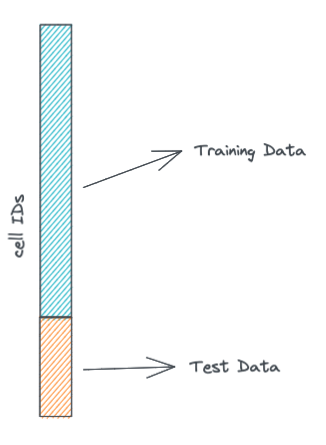

In [ ]:
split = .8 # we take 80% of the cells for the training dataset, the rest will be in the validation dataset
train_barcodes = np.random.choice(adata.obs.index, replace=False, size=int(split * adata.shape[0]))
val_barcodes = np.asarray([barcode for barcode in adata.obs.index
                           if barcode not in set(train_barcodes)])
len(train_barcodes), len(val_barcodes)

(2110, 528)

In [ ]:
train_adata = adata[train_barcodes]
val_adata = adata[val_barcodes]
train_adata.shape, val_adata.shape # (n_cells x n_genes)

((2110, 13656), (528, 13656))

**The input features**

Here we set our training and validation input data. The data matrices are both n_cells x n_genes (cells are rows, genes are columns).

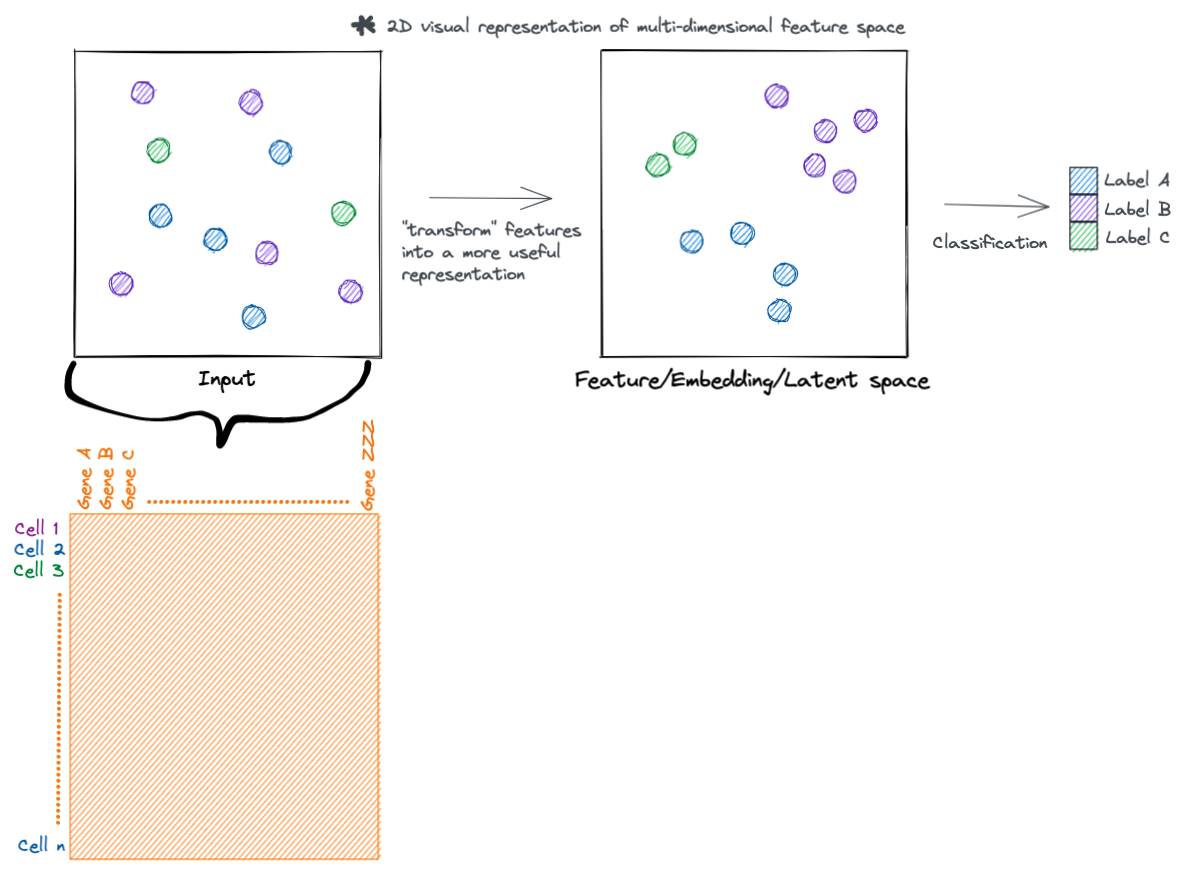

In [ ]:
X_train = train_adata.X
X_val = val_adata.X
X_train.shape, X_val.shape # (n_cells x n_genes)

((2110, 13656), (528, 13656))

**The target variable**

The target variable is the variable we want the model produce (cell type in this case).

There are seven possible cell type labels

In [ ]:
labels = sorted(set(adata.obs['label']))
labels

['B cells',
 'CD14+ Monocytes',
 'CD4 T cells',
 'CD8 T cells',
 'Dendritic cells',
 'FCGR3A+ Monocytes',
 'Megakaryocytes',
 'NK cells']

Each of which is assigned to a cell in the training dataset

In [ ]:
adata.obs[['label']]

label
index                            
AAACATACAACCAC-1      CD4 T cells
AAACATTGAGCTAC-1          B cells
AAACATTGATCAGC-1      CD4 T cells
AAACCGTGCTTCCG-1  CD14+ Monocytes
AAACCGTGTATGCG-1         NK cells
...                           ...
TTTCGAACTCTCAT-1  CD14+ Monocytes
TTTCTACTGAGGCA-1          B cells
TTTCTACTTCCTCG-1          B cells
TTTGCATGAGAGGC-1          B cells
TTTGCATGCCTCAC-1      CD4 T cells

[2638 rows x 1 columns]

Usually, machine learning libraries expect numerical values instead of strings when specifying labels.

For multi-label classification, this is typically done via a one-hot encoding.

A one-hot encoding is a binary matrix where each row is a sample and each column is a possible label (cell types in this case). Each row will have all 0s except for one value which is a 1. This 1 indicates the label for that sample.

Notably, one-hot encoding also turns the data into a *probability distribution*, where the values in the matrix are the probability a cell is of a certain cell type. This will come into play later...

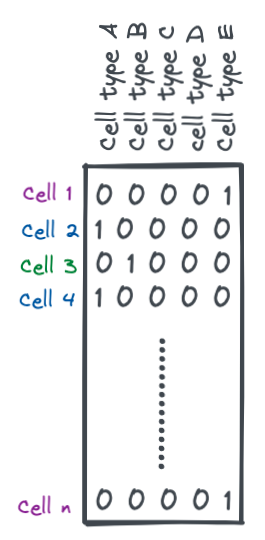

In [ ]:
encoder = OneHotEncoder()
encoder.fit(adata.obs['label'].to_numpy().reshape(-1, 1))
y_train = encoder.transform(train_adata.obs['label'].to_numpy().reshape(-1, 1)).toarray()
y_val = encoder.transform(val_adata.obs['label'].to_numpy().reshape(-1, 1)).toarray()
y_train.shape, y_val.shape

((2110, 8), (528, 8))

In [ ]:
labels = encoder.categories_[0]
labels

array(['B cells', 'CD14+ Monocytes', 'CD4 T cells', 'CD8 T cells',
       'Dendritic cells', 'FCGR3A+ Monocytes', 'Megakaryocytes',
       'NK cells'], dtype=object)

In [ ]:
y_train

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

**Making the dataloader**

PyTorch, the Python library we will be using, has abstractions for a *Dataset* and *Dataloader*. These objects help feed training and validation data into the neural network during training.

In [ ]:
# first we need to make our model inputs tensors
X_train, X_val = torch.tensor(X_train), torch.tensor(X_val)
y_train, y_val = torch.tensor(y_train), torch.tensor(y_val)

In [ ]:
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
val_dataset = torch.utils.data.TensorDataset(X_val, y_val)

During neural network training, data is fed into the network in *batches*, which are small subsets of the input data. There are other multiple reasons for doing this, but mainly it helps alleviate memory issues that would be caused in datasets with large numbers of samples.

During an iteration of training, every batch is fed through the model. Each iteration is known as an *epoch*. Models are typically trained for several epochs.

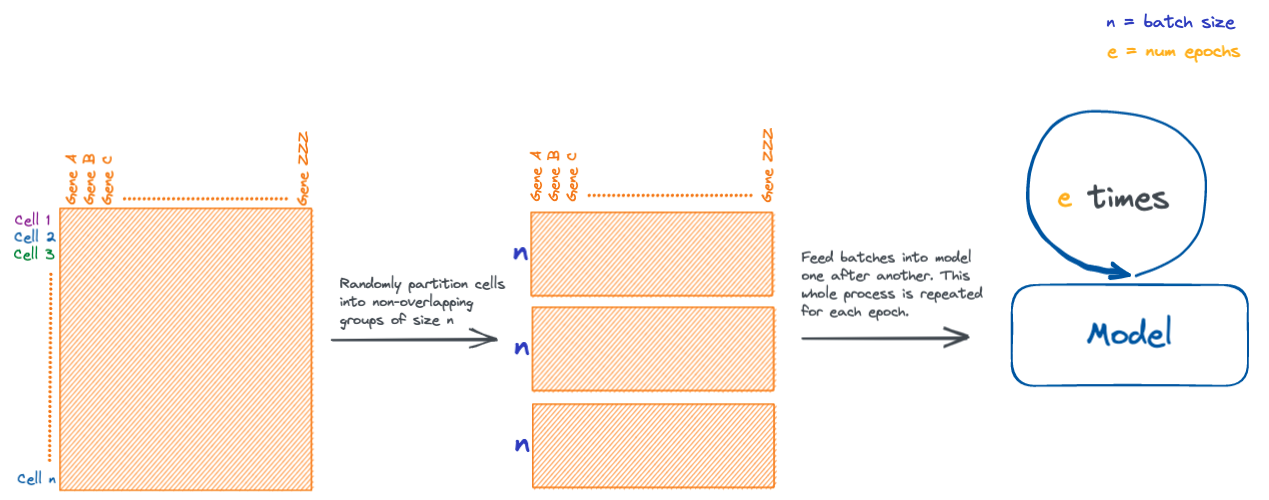

In [ ]:
# the PyTorch dataset is used to make a DataLoader
batch_size = 64
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

In [ ]:
# we can inspect the contents of one batch
# the first output are the input features, the second are the class labels
b_X, b_y = next(iter(train_dataloader))
b_X.shape, b_X # feature size should be batch_size X num_genes

(torch.Size([64, 13656]),
 tensor([[-0.0581, -0.0336, -0.0417,  ..., -0.0524, -0.2039, -0.1593],
         [-0.0581, -0.0336, -0.0417,  ..., -0.0524, -0.2039, -0.1593],
         [-0.0581, -0.0336, -0.0417,  ..., -0.0524, -0.2039, -0.1593],
         ...,
         [-0.0581, -0.0336, -0.0417,  ..., -0.0524, -0.2039, -0.1593],
         [-0.0581, -0.0336, -0.0417,  ..., -0.0524, -0.2039, -0.1593],
         [-0.0581, -0.0336, -0.0417,  ..., -0.0524, -0.2039, -0.1593]]))

In [ ]:
b_y.shape, b_y[0] # one-hot encoded matrix, should be batch_size X num_labels

(torch.Size([64, 8]),
 tensor([0., 0., 0., 1., 0., 0., 0., 0.], dtype=torch.float64))

#### Building the model

###### A simple linear layer

A neural network transforms inputs using **weights**. Weights are the values used to transform inputs to each layer in the network. Thing of the weights as being somewhat analogous to the principle components in a PCA, in that principle components are used to *project* inputs into a different feature space.

Different types of neural network layers have different twists on this process, but the general idea of projecting inputs into a different feature still holds.

Below is the formula for a simple linear layer.

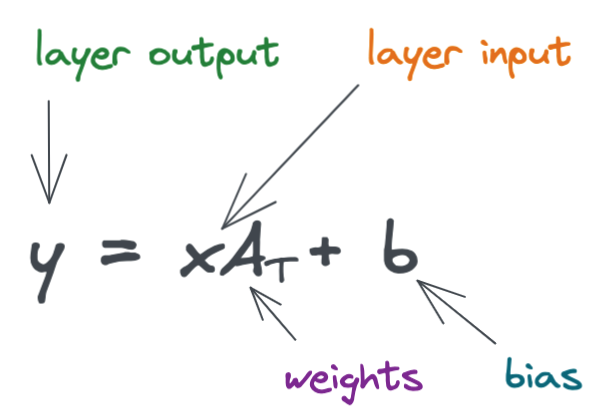

Here, we look a simple diagram of a neureal network with two linear layers. (Remember that neural networks typically contain many layers, I'm showing just two layers in the following example for simplicity).

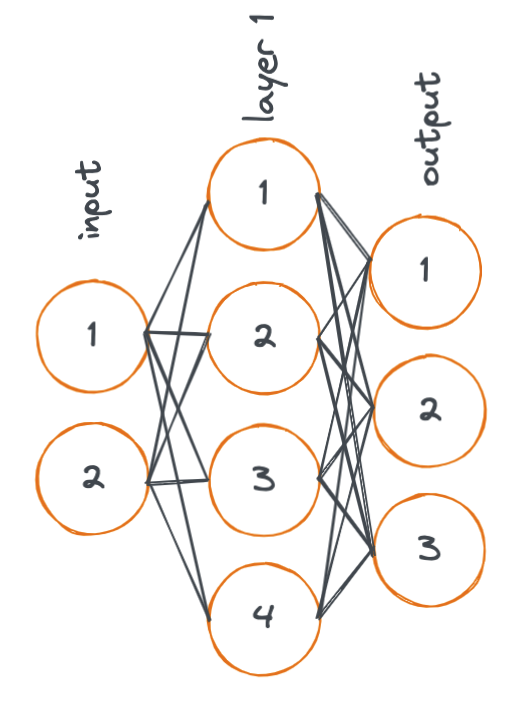

In the diagram, each node represents an *activation*, and each line represents a *weight*. An activiation is a value that is input (or output) to/from a layer in the neural network.

Lets take an example problem where we would like to apply a neural network to .... fruit!

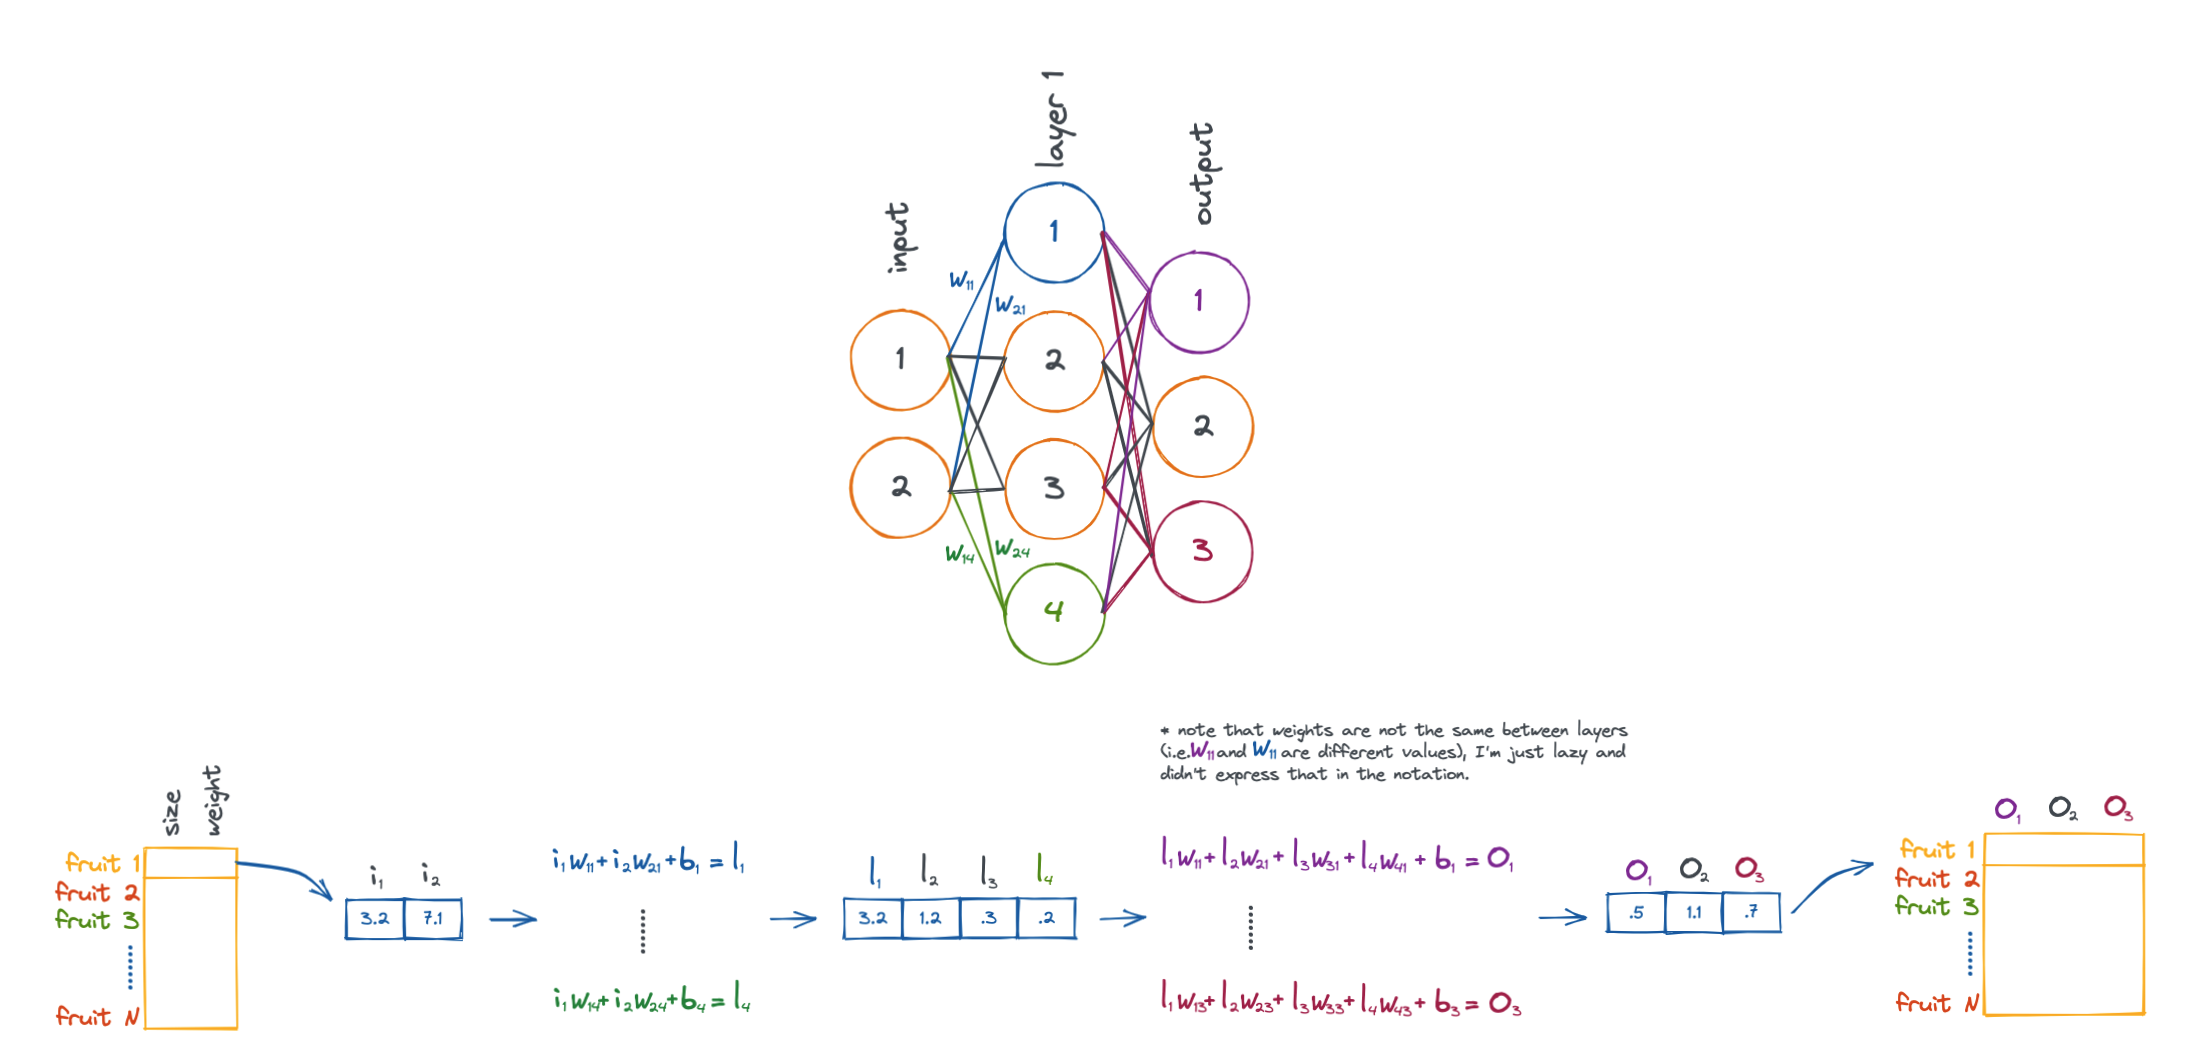

Above shows the process of taking a piece of fruit that has two input features (size and weight), and passing it through the neural network until we have an output that is in 3-dimensional feature space (O1, O2, and O3).

Note that the weights (W) and biases (b) are what influence *how* the fruit is transformed. These values are what are updated by the neural network in attempt to accomplish a given task.

So, when we talk about a neural network "learning", what we mean is that it is updating its interal weights and biases. Collectively, weights and biases are known as *parameters* of the network. Modern neural networks can scale to have billions of parameters!

Now that we have a general feel for the math of linear layers, we can cast the above process as a series of *matrix* operations, allowing us to pass multiple samples through the network simultaneously.

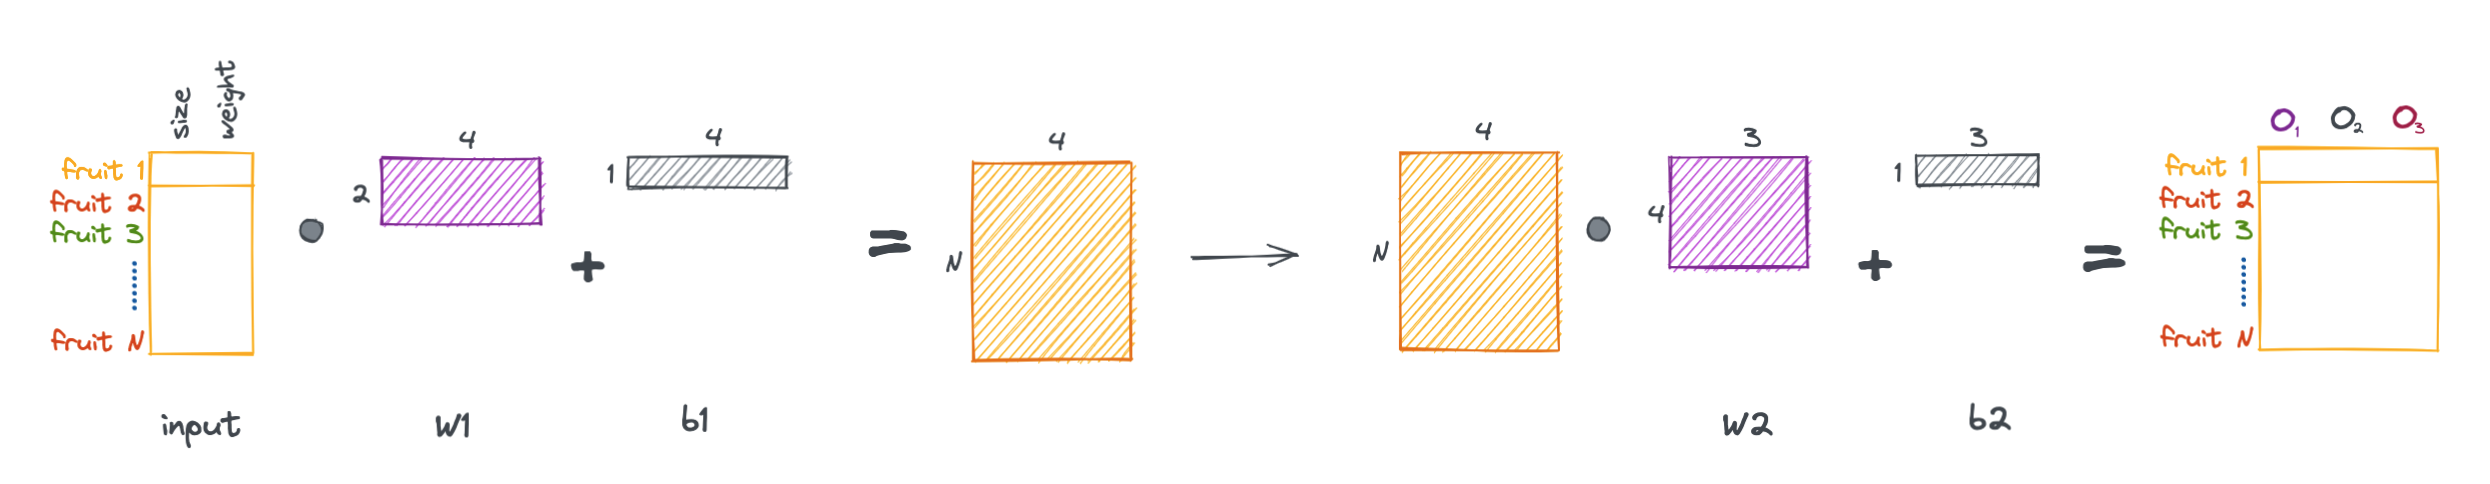

More generally, we can formulate a linear layer as the following.

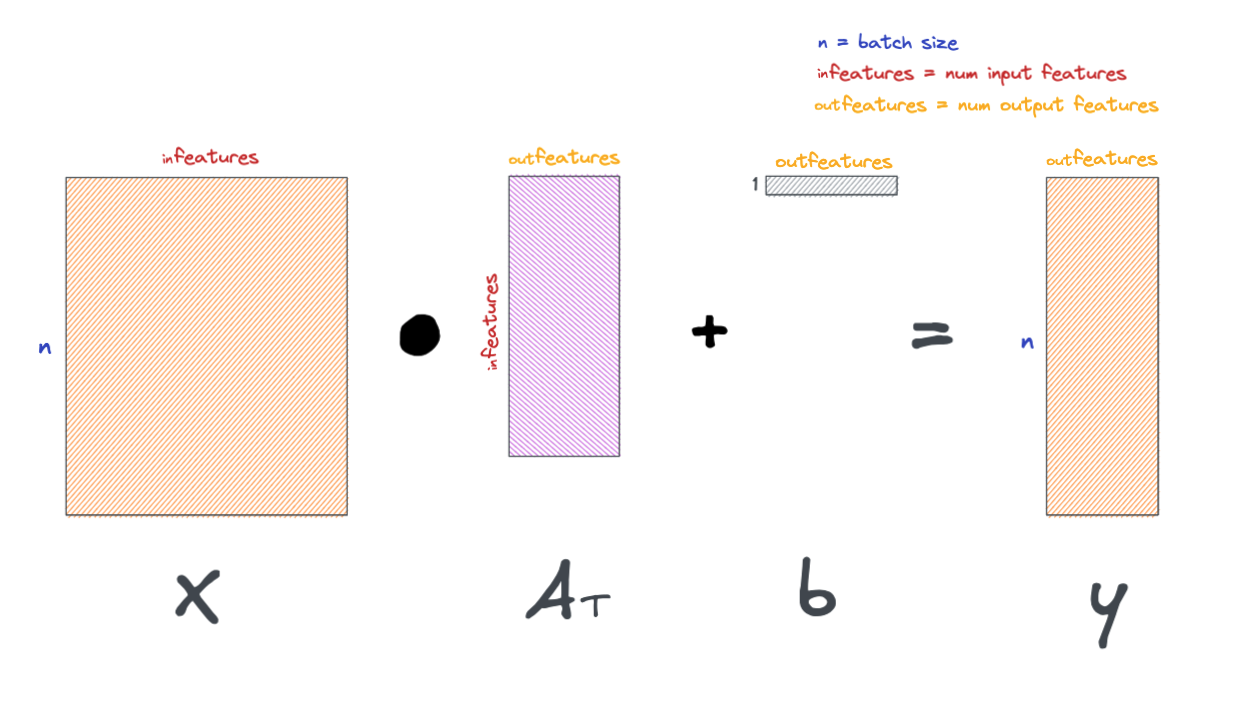

These layers are visually represented in a variety of ways, below are a few examples.

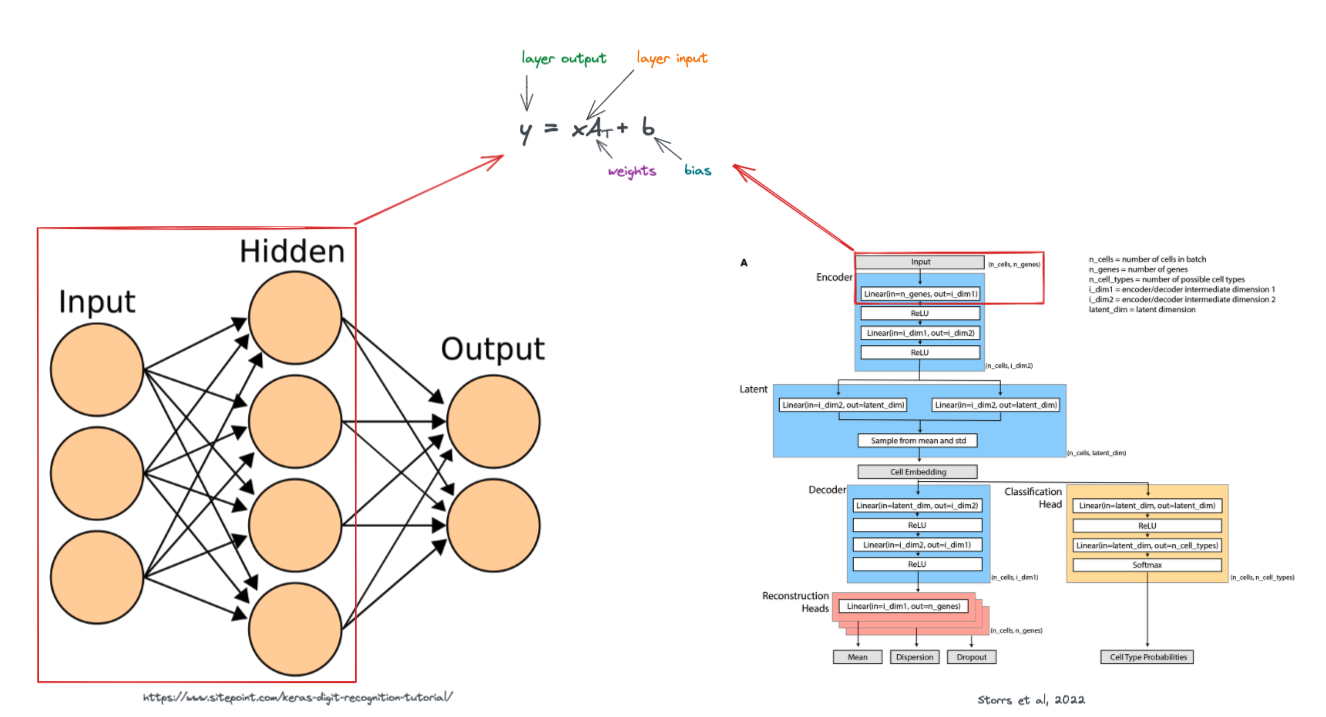

The weights of a network (also known collectively as parameters), control what type of outputs the model gives. As the model learns, it updates it's weights, allowing it to make better predictions.

There's one more thing to mention about layers in neural networks, typically, they are followed by a **non-linear activation function**.

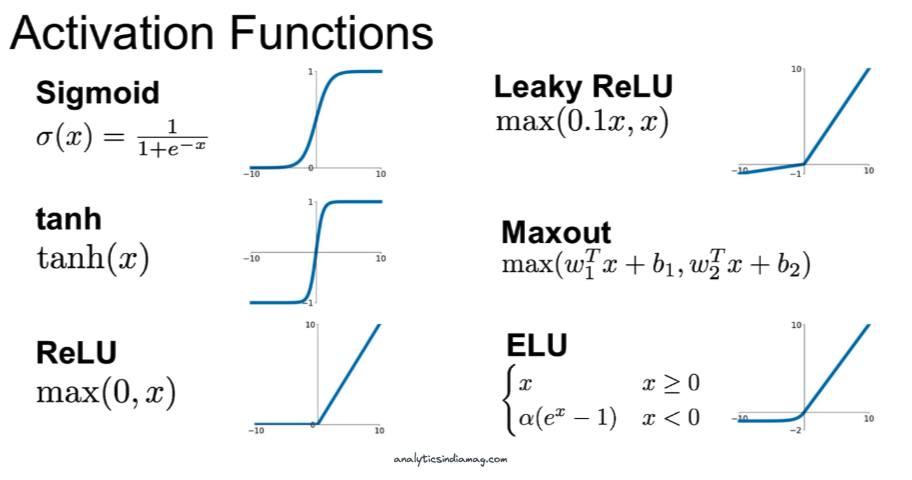

Each one of these non-linear functions alters the output values of each layer in a non-linear fashion. For example, if we take the rectified linear unit (ReLU) activation function, any values in output of a layer <0 be set to zero, and all values >0 will remain the same.

That's all there is to a linear layer. There are other types of layers too, such as convolutional layers used in imaging, but we'll save those for the future.

Here, we initialize a simple linear layer with pytorch and see it in action.

In [ ]:
n_genes = X_train.shape[1]
out_features = 128
layer = torch.nn.Linear(in_features=n_genes, out_features=out_features)
layer

Linear(in_features=13656, out_features=128, bias=True)

We can test drive this layer by feeding one of our input batches defined earlier.

Also, a quick note: the outputs of each layer throughout the network are known as *activations*.

In [ ]:
b_X.shape

torch.Size([64, 13656])

In [ ]:
activations = layer(b_X) # feed inputs through layer, b_X is batch_size X n_genes
activations = torch.functional.F.relu(activations) # put layer outputs through ReLU non-linear function.
activations.shape, activations

(torch.Size([64, 128]),
 tensor([[1.1578, 0.0000, 0.4584,  ..., 0.2042, 0.0844, 0.0000],
         [0.1278, 0.0000, 0.2556,  ..., 0.4005, 0.7170, 0.0000],
         [0.0000, 0.0000, 1.1884,  ..., 0.4901, 0.0000, 0.0000],
         ...,
         [0.0000, 0.8649, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.2696, 0.3765, 0.0000],
         [0.3116, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
        grad_fn=<ReluBackward0>))

Below is a schematic of the operations we just performed in the above cell:

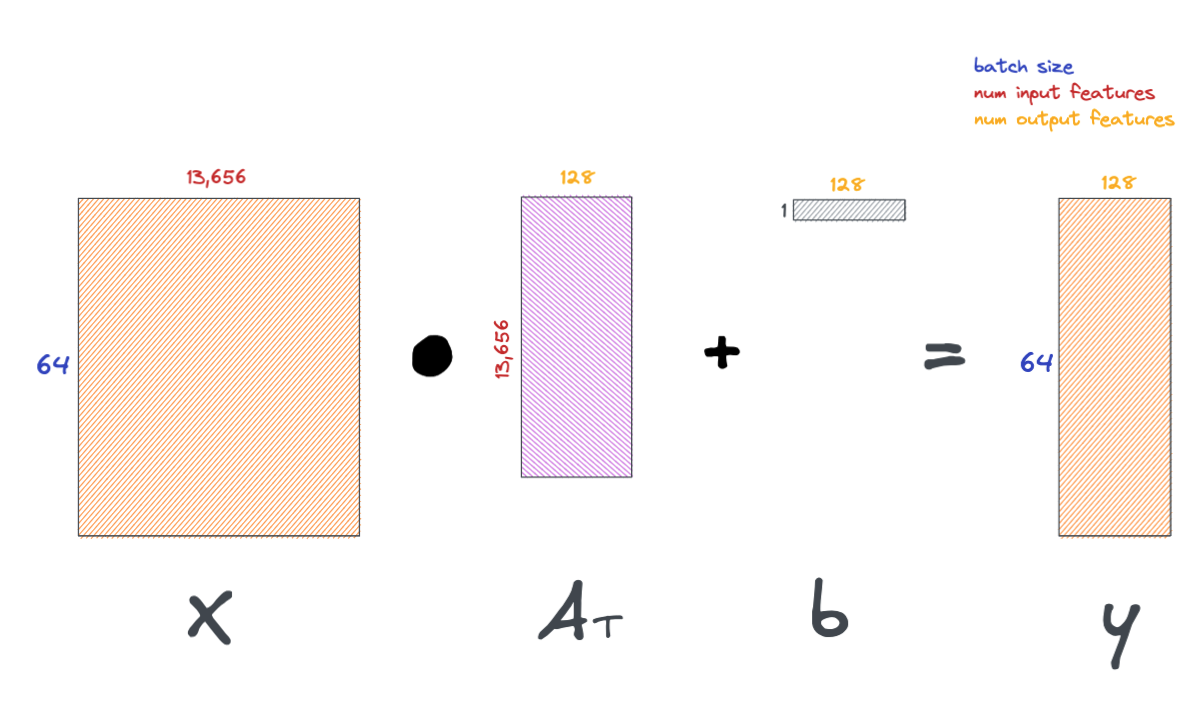

###### The loss function

There's one last piece before we can build an actual model. The loss function.

Loss functions define what we want the model to *do*.

If we want the model to classify something, the loss function will be related to label classification. If we want to cluster something, the loss function will probably be related to constraining one of the hidden layers of the model in some way. There is no limit to the number/type/variety of loss functions you can use in a model. This is part of what makes deep learning so powerful.

More complex loss functions are out of scope for this notebook, but we will cover the popular *cross-entropy loss function*. This is the main loss function used for multi-label classification problems (which is what we need here, as a cell could be classified as one of many different cell types).

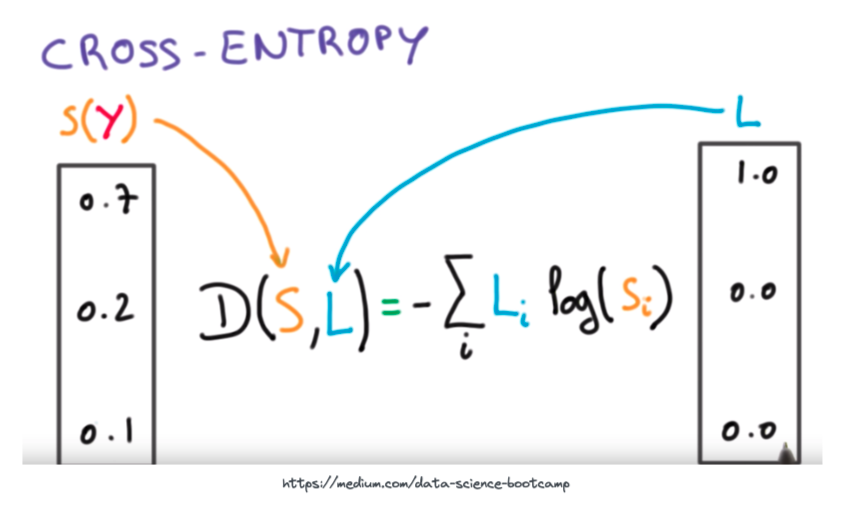

The essence of the above equation is that we are comparing the output probabilities of the neural network *S* to the actual groundtruth target probabilities *L*. For an intuitive visual on how the output of the cross-entropy loss function looks with increasing difference between predicted and target values see the plot below.

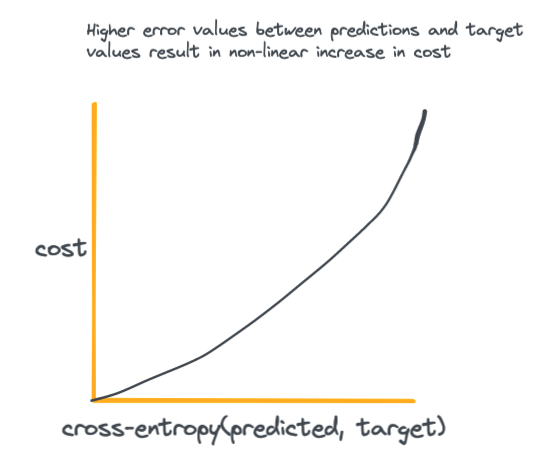

The key takeaway here is that high loss values *disproportionately* result in higher cost to the network, which incentivices the network to do everything it can to achieve the smallest possible difference betweeen predicted and target values.

###### Output probabilities

So how do we get output probabilities to feed into the cross-entropy loss function in the first place?

We use a function called *Softmax*. The softmax function is applied to the last layer of the neural network. It's job is to convert the activations from the last layer of the neural network to probabilities.

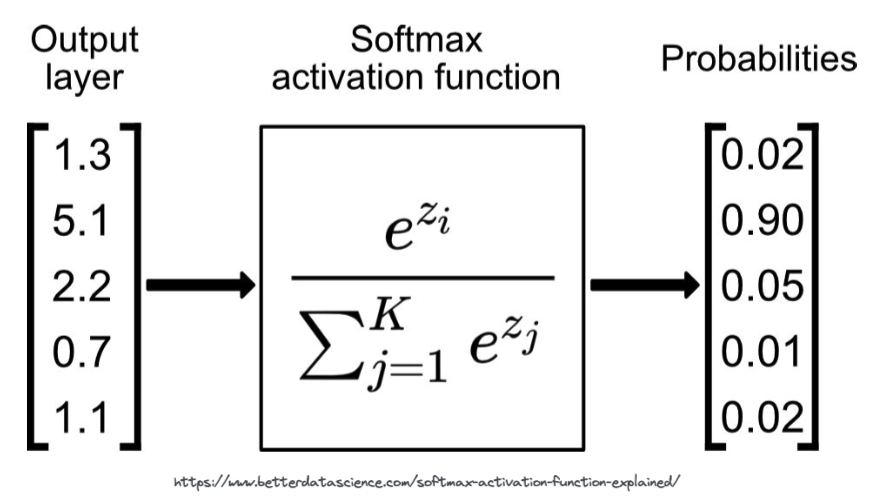

In [ ]:
# we can test the above with the PyTorch softmax function
x = torch.tensor([1.3, 5.1, 2.2, 0.7, 1.1])
torch.functional.F.softmax(x)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


tensor([0.0202, 0.9025, 0.0497, 0.0111, 0.0165])

Notice how the softmax function squishes/sharpens the activations of the final layer while simultaneously making them add up to 1.

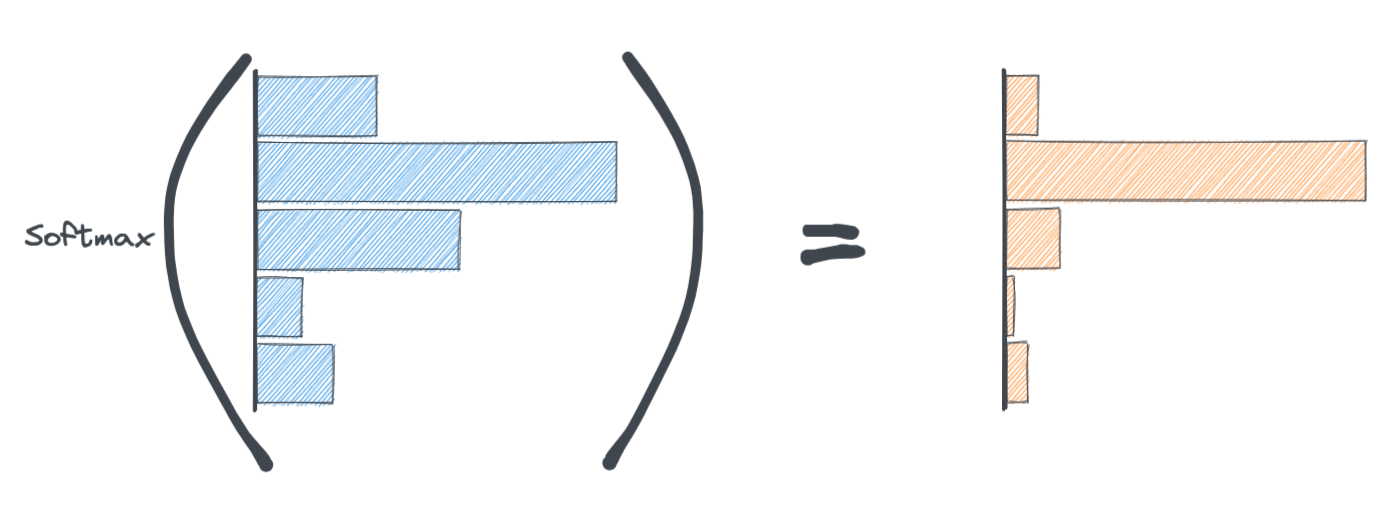

This probability distribution is ultimately what goes into the cross-entropy loss function.

###### Putting it all together

Next, we'll create a model using the components we discussed above
+ Multiple linear layers
+ Softmax layer
+ cross-entropy loss

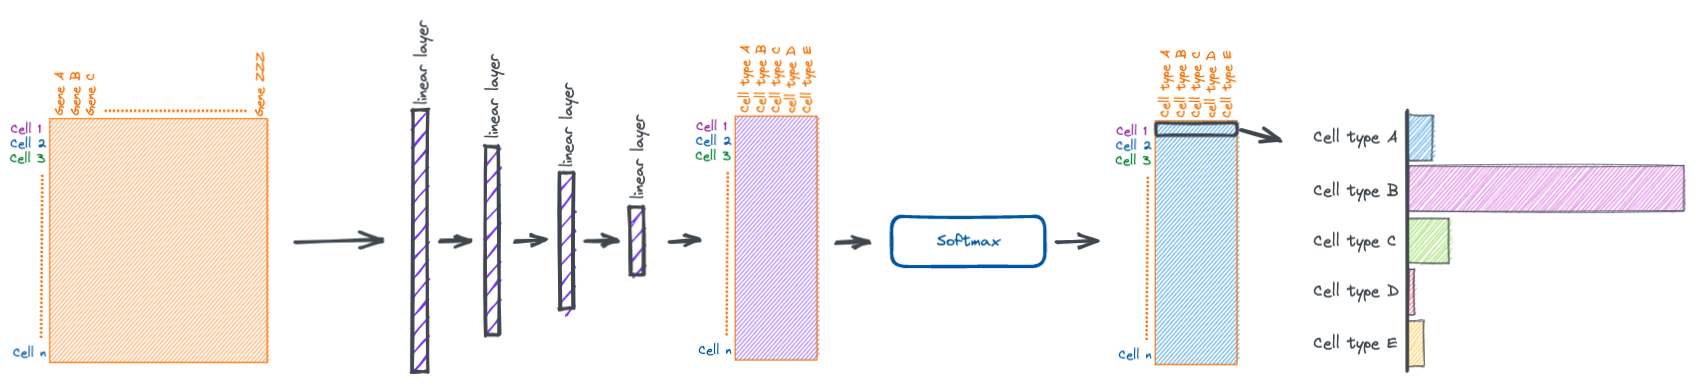

The `torch.nn.Module` class in PyTorch makes it easy to stack multiple layers together.

Here we make a simple four layer network.

Some things to take note of:
+ the number of input features for a layer must match the number of output features of the previous layer.
+ the last linear layer must output activations that are the same length as the number of possible cell types. this is because those activiations will be turned into a probability distribution by the *softmax* function, so each position in the tensor will be a probability for a specific cell type.
+ we also apply dropout between the first couple layers. dropout is a technique where random activations are set to zero with some probability (usually 20-50%) during training. this helps with generalizaing the model to data it hasn't seen before.


In [ ]:
class SimplePollock(torch.nn.Module):
  def __init__(self, n_genes, n_labels):
    super(SimplePollock, self).__init__()

    self.n_genes = n_genes # number of genes in input
    self.n_labels = n_labels # number of possible cell types

    self.layers = torch.nn.Sequential(
      torch.nn.Linear(in_features=n_genes, out_features=1028), # layer 1
      torch.nn.ReLU(),
      torch.nn.Dropout(p=.2), # randomly zero 20% of input tensor, helps with generalization
      torch.nn.Linear(in_features=1028, out_features=256), # layer 2
      torch.nn.ReLU(),
      torch.nn.Dropout(p=.2), # randomly zero 20% of input tensor, helps with generalization
      torch.nn.Linear(in_features=256, out_features=128), # layer 3
      torch.nn.ReLU(),
    )

    self.final_layer = torch.nn.Sequential(
        torch.nn.Linear(in_features=128, out_features=self.n_labels), # output layer must be the same length as the total number of classes
        torch.nn.Softmax(dim=1), # creates prediction probabilities
    )

    self.loss_function = torch.nn.CrossEntropyLoss() # we will use cross entropy loss

  def calculate_loss(self, predicted, target):
    return self.loss_function(predicted, target) # use cross entropy to calculate loss

  def final_activations(self, x):
    """Return activations of second to last layer"""
    return self.layers(x)

  def forward(self, x):
    """
    Defines how activations are propogated through the network.

    In our case, they go through four layers followed by a softmax function.
    """
    x = self.layers(x)
    x = self.final_layer(x)
    return x

model = SimplePollock(n_genes, len(labels))
model

SimplePollock(
  (layers): Sequential(
    (0): Linear(in_features=13656, out_features=1028, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=1028, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
  )
  (final_layer): Sequential(
    (0): Linear(in_features=128, out_features=8, bias=True)
    (1): Softmax(dim=1)
  )
  (loss_function): CrossEntropyLoss()
)

We can do a sanity check and test run some data through the model.

In [ ]:
probs = model(b_X)
probs.shape, probs[0] # view output shape and probabilities for first cell in batch

(torch.Size([64, 8]),
 tensor([0.1184, 0.1158, 0.1321, 0.1377, 0.1319, 0.1282, 0.1157, 0.1202],
        grad_fn=<SelectBackward0>))

Here we define some model hyperparameters. Hyperparameters are model parameters that influence how the model trains/behaves. For example, the number of epochs (i.e. number of times the model iterates through the training data) is a hyperparameter.

In [ ]:
n_epochs = 10 # num of iterations we will go through the training data
lr = .0001 # learning rate, I didn't talk about it above, but think of it as controlling how fast the model updates its parameters.

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr) # I also havent talked about optimizers, but this controls the method the model uses to update its parameters

Deep learning models run faster on GPU, here we move our model to the GPU

In [ ]:
model = model.cuda()

Below we define a *training loop*. Inside the loop we feed batches into our model, calculate the loss, and update model parameters.

In [ ]:
def accuracy(y_pred, y_true):
  """helper accuracy function"""
  if y_pred.is_cuda:
    y_pred, y_true = y_pred.cpu().detach(), y_true.cpu().detach()
  pred_labels = np.asarray([labels[i] for i in np.argmax(y_pred, axis=1)])
  true_labels = np.asarray([labels[i] for i in np.argmax(y_true, axis=1)])
  return np.sum(pred_labels==true_labels) / len(pred_labels)

In [ ]:
train_losses, val_losses, train_accs, val_accs = [], [], [], [] # track training history
for i in range(n_epochs):
  train_loss, val_loss = 0., 0.
  train_acc, val_acc = 0., 0.

  # training
  model.train()
  for x, y in train_dataloader:
    x, y = x.cuda(), y.cuda() # move inputs to GPU

    optimizer.zero_grad() # optimizer gradients need to be zeroed on every batch

    probs = model(x) # get output probabilities from model
    loss = model.calculate_loss(probs, y) # calculate loss for predictions vs. targets
    train_loss += loss.item() # add loss for batch to total training loss
    train_acc += accuracy(probs, y) # add accuracy for batch to total training accuracy

    loss.backward() # propogate gradients
    optimizer.step() # adjust model parameters based on loss

  # validation
  model.eval()
  with torch.no_grad(): # we dont want to update parameters during validation.
    for x, y in val_dataloader:
      x, y = x.cuda(), y.cuda() # move inputs to GPU
      probs = model(x) # get output probabilities from model
      loss = model.calculate_loss(probs, y) # calculate loss for predictions vs. targets
      val_loss += loss.item() # add loss for batch to total validation loss
      val_acc += accuracy(probs, y) # add accuracy for batch to total validation accuracy

  # scale metrics to total number of batches
  train_loss /= len(train_dataloader) # scale to total number of batches
  val_loss /= len(val_dataloader) # scale to total number of batches
  train_acc /= len(train_dataloader) # scale to total number of batches
  val_acc /= len(val_dataloader) # scale to total number of batches

  train_losses.append(train_loss)
  val_losses.append(val_loss)
  train_accs.append(train_acc)
  val_accs.append(val_acc)

  # print metrics for epoch
  print(f'Epoch: {i}, Train loss: {train_loss}, Val loss: {val_loss}, Train acc: {train_acc}, Val acc: {val_acc}')

Epoch: 0, Train loss: 1.950341985938763, Val loss: 1.6846236054682069, Train acc: 0.5323344330400782, Val acc: 0.6267361111111112
Epoch: 1, Train loss: 1.5988501255033594, Val loss: 1.544216648572021, Train acc: 0.6758614369501467, Val acc: 0.78125
Epoch: 2, Train loss: 1.4331558269638849, Val loss: 1.4294813372608688, Train acc: 0.8796737536656891, Val acc: 0.9027777777777778
Epoch: 3, Train loss: 1.3174032488380825, Val loss: 1.3883267717642918, Train acc: 0.9696816959921799, Val acc: 0.90625
Epoch: 4, Train loss: 1.2959041233636068, Val loss: 1.3783715921971533, Train acc: 0.9800983626588465, Val acc: 0.9097222222222222
Epoch: 5, Train loss: 1.2881625276131743, Val loss: 1.376359795530637, Train acc: 0.990530303030303, Val acc: 0.9097222222222222
Epoch: 6, Train loss: 1.2815604465899813, Val loss: 1.3725135394682486, Train acc: 0.9943181818181818, Val acc: 0.9149305555555556
Epoch: 7, Train loss: 1.279415316324415, Val loss: 1.3690197923117213, Train acc: 0.9976325757575758, Val acc

Plotting the training/validation loss and and accuracy over time.

In [ ]:
source = pd.DataFrame.from_dict({
    'Epochs': list(range(n_epochs)),
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_accuracy': train_accs,
    'val_accuracy': val_accs
})

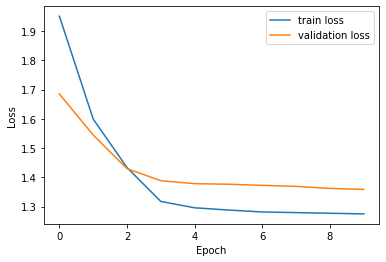

In [ ]:
plt.plot(source['Epochs'], source['train_loss'], label='train loss')
plt.plot(source['Epochs'], source['val_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

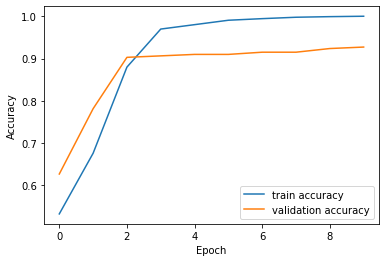

In [ ]:
plt.plot(source['Epochs'], source['train_accuracy'], label='train accuracy')
plt.plot(source['Epochs'], source['val_accuracy'], label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

Let's get predictions for the training and validation datasets from the trained model

In [ ]:
with torch.no_grad():
  train_probs = model(X_train.cuda()).cpu().detach()
  val_probs = model(X_val.cuda()).cpu().detach()
train_probs.shape, train_probs[0] # There are 8 probabilities, one for each possible cell type. Should be n_cells X n_labels.

(torch.Size([2110, 8]),
 tensor([4.9872e-06, 4.7461e-04, 2.2590e-06, 3.7907e-05, 9.3467e-05, 9.9913e-01,
         2.0607e-04, 5.1019e-05]))

Viewing the validation classifications

In [ ]:
def get_confusion_matrix(y_pred, y_true, normalize=None):
  """helper accuracy function"""
  if y_pred.is_cuda:
    y_pred, y_true = y_pred.cpu().detach(), y_true.cpu().detach()
  pred_labels = np.asarray([labels[i] for i in np.argmax(y_pred, axis=1)])
  true_labels = np.asarray([labels[i] for i in np.argmax(y_true, axis=1)])
  df = pd.DataFrame(
      data=confusion_matrix(true_labels, pred_labels, labels=labels, normalize=normalize),
      index=labels, columns=labels)
  df.index.name = 'Groundtruth'
  df.columns.name = 'Predicted'
  return df

In [ ]:
get_confusion_matrix(val_probs, y_val)

Predicted          B cells  CD14+ Monocytes  CD4 T cells  CD8 T cells  \
Groundtruth                                                             
B cells                 63                0            1            0   
CD14+ Monocytes          0               93            0            0   
CD4 T cells              0                0          234            8   
CD8 T cells              0                0           18           51   
Dendritic cells          0                3            0            0   
FCGR3A+ Monocytes        0                2            0            0   
Megakaryocytes           0                0            0            0   
NK cells                 0                0            0            3   

Predicted          Dendritic cells  FCGR3A+ Monocytes  Megakaryocytes  \
Groundtruth                                                             
B cells                          0                  0               0   
CD14+ Monocytes                  0                  0               0   
CD4 T cells                      2                  1               0   
CD8 T cells                      0                  0               0   
Dendritic cells                  2                  0               0   
FCGR3A+ Monocytes                0                 18               0   
Megakaryocytes                   0                  0               5   
NK cells                         0                  0               0   

Predicted          NK cells  
Groundtruth                  
B cells                   0  
CD14+ Monocytes           0  
CD4 T cells               0  
CD8 T cells               1  
Dendritic cells           0  
FCGR3A+ Monocytes         0  
Megakaryocytes            0  
NK cells                 23

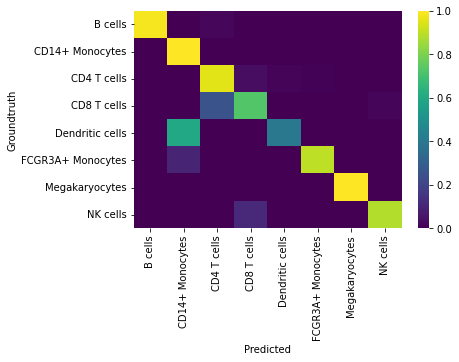

In [ ]:
import seaborn as sns
sns.heatmap(get_confusion_matrix(val_probs, y_val, normalize='true'), cmap='viridis')

Seems that most of the model confusion is between CD4 vs. CD8 T cells and between Dendritic cells and Monocytes, which makes biological sense.

At the beginning of the notebook I mentioned that you can think of the layers of the neural network as making more and more meaningful transformations. We can attempt to view those transformations via dimensionality reduction.

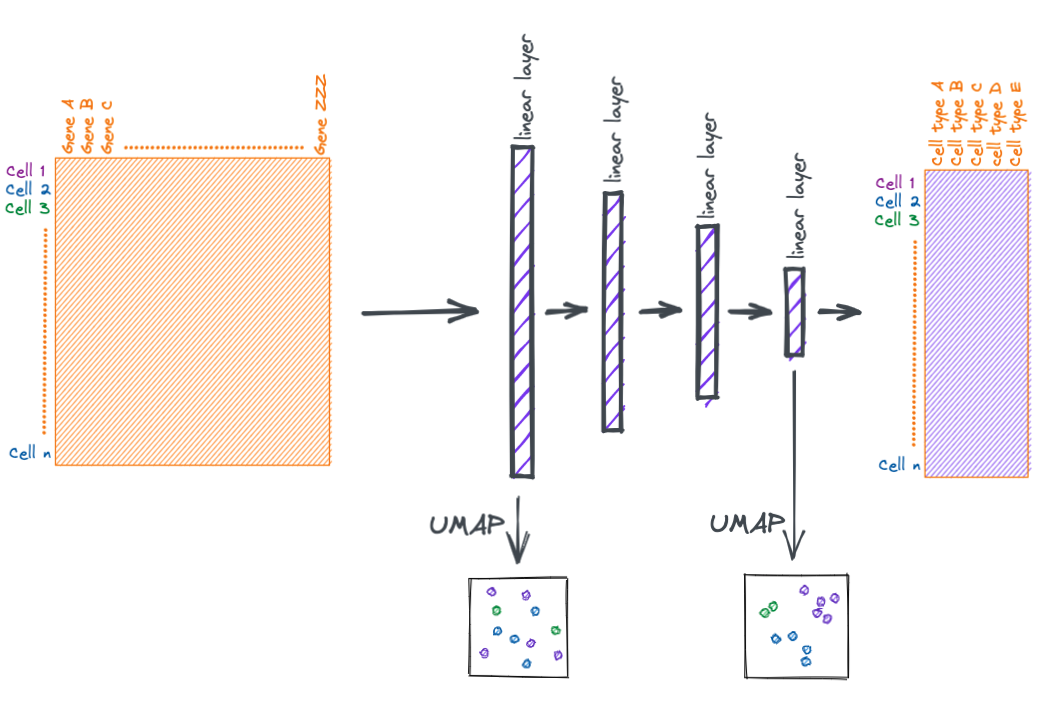

Below we take the output from the second to last layer and plot it via UMAP.

In [ ]:
with torch.no_grad():
  x = model.final_activations(X_train.cuda()).cpu().detach() # get activations of intermediate layer

emb = umap.UMAP().fit_transform(x) # apply umap dim reduction
emb.shape, emb[:5] # reduced to two dimensions

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


((2110, 2), array([[-2.010213 , -9.022686 ],
        [ 5.4682975,  6.060067 ],
        [-6.374015 ,  7.0361557],
        [ 7.970785 , -8.340453 ],
        [-7.6232176,  0.5037082]], dtype=float32))

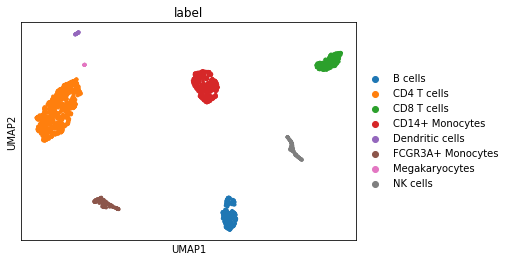

In [ ]:
train_adata.obsm['X_umap'] = emb
sc.pl.umap(train_adata, color='label')

Doing the same for the validation dataset

In [ ]:
with torch.no_grad():
  x = model.final_activations(X_val.cuda()).cpu().detach() # get activations of intermediate layer

emb = umap.UMAP().fit_transform(x) # apply umap dim reduction
emb.shape, emb[:5] # reduced to two dimensions

((528, 2), array([[12.491482 ,  5.896046 ],
        [-3.8409956, 11.411557 ],
        [ 1.0543766, -4.2629175],
        [13.338923 ,  6.236683 ],
        [-6.958151 , 13.313317 ]], dtype=float32))

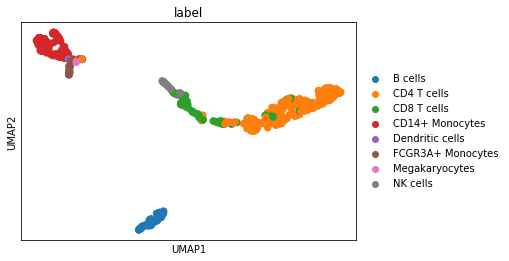

In [ ]:
val_adata.obsm['X_umap'] = emb
sc.pl.umap(val_adata, color='label')

Notice how biologically similar cells segregate together, similar to how they do in traditional single cell analysis.